# Amplitude Encoding

#### Ricky Young, Maxim Mints, Hiroki Nakayama
{ryoung98, mmints, naho5058} @stanford.edu

In this notebook we explore the amplitude encoding classical inputs and introduce a cirq implementation for the amplitude encoding created on the Pennylane platform.


Linke to Pennylane: https://pennylane.readthedocs.io/en/stable/_modules/pennylane/templates/embeddings/amplitude.html#AmplitudeEmbedding


In [27]:
# import
import cirq
import pennylane as qml
from pennylane.templates import AmplitudeEmbedding
import numpy as np

# visualization
from cirq.contrib.svg import SVGCircuit

## What is amplitude encoding?
Amplitude encoding is one of two main ways of translating classical data into quantum inputs used for qML (quantum machine learning). 


### What are the pros and cons of amplitude encoding?


## Example code

Here's a quick default example provided by Pennylane on amplitude encoding.

In [7]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(f=None):
    AmplitudeEmbedding(features=f, wires=range(2))
    return qml.expval(qml.PauliZ(0))

encoding = circuit(f=[1/2, 1/2, 1/2, 1/2])
print(dev.state)

[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]


We'll follow the 

Here's an unnormalized input:

In [9]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(f=None):
    AmplitudeEmbedding(features=f, wires=range(2),normalize=True)
    return qml.expval(qml.PauliZ(0))

encoding = circuit(f=[1/2, 1/3, 1/3, 1/2])
print(dev.state)

[0.58834841+0.j 0.39223227+0.j 0.39223227+0.j 0.58834841+0.j]


We will also explore the difference between the cirq mixed state and pure simulator provided by the pennylane plugin.

In [34]:
dev = qml.device('cirq.simulator', wires=2)

@qml.qnode(dev)
def circuit(f=None):
    AmplitudeEmbedding(features=f, wires=range(2))
    return qml.expval(qml.PauliZ(0))

encoding = circuit(f=[1/2, 1/2, 1/2, 1/2])
print(dev.state)

[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]


In [37]:
dev = qml.device('cirq.mixedsimulator', wires=2)
@qml.qnode(dev)
def circuit(f=None):
    AmplitudeEmbedding(features=f, wires=range(2))
    return qml.expval(qml.PauliZ(0))

encoding = circuit(f=[1/2, 1/2, 1/2, 1/2])
print(dev.state)

[[0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]]


### Our cirq implementation

In [15]:
# tolerance for normalization
TOLERANCE = 1e-10

# Use Mottonen state preparation to get an amplitude embedding of the states
# Adapted from https://pennylane.readthedocs.io/en/stable/_modules/pennylane/templates/state_preparations/mottonen.html#MottonenStatePreparation

def gray_code(rank):
    """Generates the Gray code of given rank.

    Args:
        rank (int): rank of the Gray code (i.e. number of bits)
    """

    def gray_code_recurse(g, rank):
        k = len(g)
        if rank <= 0:
            return

        for i in range(k - 1, -1, -1):
            char = "1" + g[i]
            g.append(char)
        for i in range(k - 1, -1, -1):
            g[i] = "0" + g[i]

        gray_code_recurse(g, rank - 1)

    g = ["0", "1"]
    gray_code_recurse(g, rank - 1)

    return g


def _matrix_M_entry(row, col):
    """Returns one entry for the matrix that maps alpha to theta.

    See Eq. (3) in `Möttönen et al. (2004) <https://arxiv.org/pdf/quant-ph/0407010.pdf>`_.

    Args:
        row (int): one-based row number
        col (int): one-based column number

    Returns:
        (float): transformation matrix entry at given row and column
    """
    # (col >> 1) ^ col is the Gray code of col
    b_and_g = row & ((col >> 1) ^ col)
    sum_of_ones = 0
    while b_and_g > 0:
        if b_and_g & 0b1:
            sum_of_ones += 1

        b_and_g = b_and_g >> 1

    return (-1) ** sum_of_ones


def _compute_theta(alpha):
    """Maps the angles alpha of the multi-controlled rotations decomposition of a uniformly controlled rotation
     to the rotation angles used in the Gray code implementation.

    Args:
        alpha (tensor_like): alpha parameters

    Returns:
        (tensor_like): rotation angles theta
    """
    ln = alpha.shape[0]
    k = np.log2(alpha.shape[0])

    M_trans = np.zeros(shape=(ln, ln))
    for i in range(len(M_trans)):
        for j in range(len(M_trans[0])):
            M_trans[i, j] = _matrix_M_entry(j, i)

    theta = np.dot(M_trans, alpha)

    return theta / 2 ** k


def _uniform_rotation_dagger(gate, alpha, control_wires, target_wire, circuit):
    r"""Applies a uniformly-controlled rotation to the target qubit.

    A uniformly-controlled rotation is a sequence of multi-controlled
    rotations, each of which is conditioned on the control qubits being in a different state.
    For example, a uniformly-controlled rotation with two control qubits describes a sequence of
    four multi-controlled rotations, each applying the rotation only if the control qubits
    are in states :math:`|00\rangle`, :math:`|01\rangle`, :math:`|10\rangle`, and :math:`|11\rangle`, respectively.

    To implement a uniformly-controlled rotation using single qubit rotations and CNOT gates,
    a decomposition based on Gray codes is used. For this purpose, the multi-controlled rotation
    angles alpha have to be converted into a set of non-controlled rotation angles theta.

    For more details, see `Möttönen and Vartiainen (2005), Fig 7a<https://arxiv.org/pdf/quant-ph/0504100.pdf>`_.

    Args:
        gate (.Operation): gate to be applied, needs to have exactly one parameter
        alpha (tensor_like): angles to decompose the uniformly-controlled rotation into multi-controlled rotations
        control_wires (array[int]): wires that act as control
        target_wire (int): wire that acts as target
    """

    theta = _compute_theta(alpha)

    gray_code_rank = len(control_wires)

    if gray_code_rank == 0:
        if theta[0] != 0.0:
            circuit.append(gate(theta[0])(target_wire))
        return

    code = gray_code(gray_code_rank)
    num_selections = len(code)

    control_indices = [
        int(np.log2(int(code[i], 2) ^ int(code[(i + 1) % num_selections], 2)))
        for i in range(num_selections)
    ]

    for i, control_index in enumerate(control_indices):
        if theta[i] != 0.0:
            circuit.append(gate(theta[i])(target_wire))
        circuit.append(cirq.CNOT(control_wires[control_index], target_wire))


def _get_alpha_z(omega, n, k):
    r"""Computes the rotation angles required to implement the uniformly-controlled Z rotation
    applied to the :math:`k`th qubit.

    The :math:`j`th angle is related to the phases omega of the desired amplitudes via:

    .. math:: \alpha^{z,k}_j = \sum_{l=1}^{2^{k-1}} \frac{\omega_{(2j-1) 2^{k-1}+l} - \omega_{(2j-2) 2^{k-1}+l}}{2^{k-1}}

    Args:
        omega (tensor_like): phases of the state to prepare
        n (int): total number of qubits for the uniformly-controlled rotation
        k (int): index of current qubit

    Returns:
        array representing :math:`\alpha^{z,k}`
    """
    indices1 = [
        [(2 * j - 1) * 2 ** (k - 1) + l - 1 for l in range(1, 2 ** (k - 1) + 1)]
        for j in range(1, 2 ** (n - k) + 1)
    ]
    indices2 = [
        [(2 * j - 2) * 2 ** (k - 1) + l - 1 for l in range(1, 2 ** (k - 1) + 1)]
        for j in range(1, 2 ** (n - k) + 1)
    ]

    term1 = np.take(omega, indices=indices1)
    term2 = np.take(omega, indices=indices2)
    diff = (term1 - term2) / 2 ** (k - 1)

    return np.sum(diff, axis=1)


def _get_alpha_y(a, n, k):
    r"""Computes the rotation angles required to implement the uniformly controlled Y rotation
    applied to the :math:`k`th qubit.

    The :math:`j`-th angle is related to the absolute values, a, of the desired amplitudes via:

    .. math:: \alpha^{y,k}_j = 2 \arcsin \sqrt{ \frac{ \sum_{l=1}^{2^{k-1}} a_{(2j-1)2^{k-1} +l}^2  }{ \sum_{l=1}^{2^{k}} a_{(j-1)2^{k} +l}^2  } }

    Args:
        a (tensor_like): absolute values of the state to prepare
        n (int): total number of qubits for the uniformly-controlled rotation
        k (int): index of current qubit

    Returns:
        array representing :math:`\alpha^{y,k}`
    """
    indices_numerator = [
        [(2 * (j + 1) - 1) * 2 ** (k - 1) + l for l in range(2 ** (k - 1))]
        for j in range(2 ** (n - k))
    ]
    numerator = np.take(a, indices=indices_numerator)
    numerator = np.sum(np.abs(numerator) ** 2, axis=1)

    indices_denominator = [[j * 2 ** k + l for l in range(2 ** k)] for j in range(2 ** (n - k))]
    denominator = np.take(a, indices=indices_denominator)
    denominator = np.sum(np.abs(denominator) ** 2, axis=1)

    # Divide only where denominator is zero, else leave initial value of zero.
    # The equation guarantees that the numerator is also zero in the corresponding entries.

    with np.errstate(divide="ignore", invalid="ignore"):
        division = numerator / denominator

    division = np.where(denominator != 0.0, division, 0.0)

    return 2 * np.arcsin(np.sqrt(division))

def mottonenStatePrep(state_vector, qubits, circuit):

        a = np.abs(state_vector)
        omega = np.angle(state_vector)

        # change ordering of wires, since original code
        # was written for IBM machines
        wires_reverse = qubits[::-1]

        # Apply inverse y rotation cascade to prepare correct absolute values of amplitudes
        for k in range(len(wires_reverse), 0, -1):
            alpha_y_k = _get_alpha_y(a, len(wires_reverse), k)
            control = wires_reverse[k:]
            target = wires_reverse[k - 1]
            _uniform_rotation_dagger(cirq.ry, alpha_y_k, control, target, circuit)

        # If necessary, apply inverse z rotation cascade to prepare correct phases of amplitudes
        if not np.allclose(omega, 0):
            for k in range(len(wires_reverse), 0, -1):
                alpha_z_k = _get_alpha_z(omega, len(wires_reverse), k)
                control = wires_reverse[k:]
                target = wires_reverse[k - 1]
                if len(alpha_z_k) > 0:
                    _uniform_rotation_dagger(cirq.rz, alpha_z_k, control, target, circuit)

         
# The below is borrowed from https://pennylane.readthedocs.io/en/stable/_modules/pennylane/templates/embeddings/amplitude.html#AmplitudeEmbedding
def _preprocess(features, wires, pad_with, normalize):
    """Validate and pre-process inputs as follows:

    * Check that the features tensor is one-dimensional.
    * If pad_with is None, check that the first dimension of the features tensor
      has length :math:`2^n` where :math:`n` is the number of qubits. Else check that the
      first dimension of the features tensor is not larger than :math:`2^n` and pad features with value if necessary.
    * If normalize is false, check that first dimension of features is normalised to one. Else, normalise the
      features tensor.
    """

    shape = features.shape

    # check shape
    if features.ndim != 1:
        raise ValueError(f"Features must be a one-dimensional tensor; got shape {shape}.")

    n_features = shape[0]
    if pad_with is None and n_features != 2 ** len(wires):
        raise ValueError(
            f"Features must be of length {2 ** len(wires)}; got length {n_features}. "
            f"Use the 'pad' argument for automated padding."
        )

    if pad_with is not None and n_features > 2 ** len(wires):
        raise ValueError(
            f"Features must be of length {2 ** len(wires)} or "
            f"smaller to be padded; got length {n_features}."
        )

    # pad
    if pad_with is not None and n_features < 2 ** len(wires):
        padding = [pad_with] * (2 ** len(wires) - n_features)
        features = np.concatenate([features, padding], axis=0)

    # normalize
    norm = np.sum(np.abs(features) ** 2)

    if not np.allclose(norm, 1.0, atol=TOLERANCE):
        if normalize or pad_with:
            features = features / np.sqrt(norm)
        else:
            raise ValueError(
                f"Features must be a vector of length 1.0; got length {norm}."
                "Use 'normalize=True' to automatically normalize."
            )

    features = features.astype(np.complex128)
    return features

def cirqAppendAmplitudeEmbedding(features, qubits, circuit, pad_with=None, normalize=False):
    features = _preprocess(features, qubits, pad_with, normalize)
    mottonenStatePrep(features, qubits, circuit)

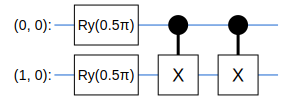

In [29]:
circuit = cirq.Circuit()
q0,q1 = cirq.GridQubit.rect(2,1)
features=np.array([1/2, 1/2, 1/2, 1/2])
cirqAppendAmplitudeEmbedding(features,np.array([q0,q1]),circuit)
SVGCircuit(circuit)

We can check the state and see that it matches the one produced on the Pennylane amplitude encoding! It should be the same since all we did was change how it takes in an input:

In [31]:
# Initialize Simulator
s=cirq.Simulator()

print('Simulate the circuit:')
results=s.simulate(circuit)
print(results)
print()

Simulate the circuit:
measurements: (no measurements)
output vector: 0.5|00⟩ + 0.5|01⟩ + 0.5|10⟩ + 0.5|11⟩



Let's also check for the non normalized state

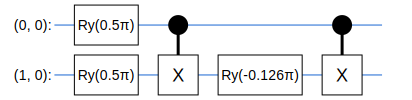

In [32]:
circuit = cirq.Circuit()
q0,q1 = cirq.GridQubit.rect(2,1)
features=np.array([1/2, 1/3, 1/3, 1/2])
cirqAppendAmplitudeEmbedding(features,np.array([q0,q1]),circuit,normalize=True)
SVGCircuit(circuit)

In [33]:
# Initialize Simulator
s=cirq.Simulator()

print('Simulate the circuit:')
results=s.simulate(circuit)
print(results)
print()

Simulate the circuit:
measurements: (no measurements)
output vector: 0.588|00⟩ + 0.392|01⟩ + 0.392|10⟩ + 0.588|11⟩

